In [1]:
using DifferentialEquations
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [443]:
# Design parameters
pᵇᵃˢᵉ = 1e3
vᵇᵃˢᵉ = 120
Zᵇᵃˢᵉ = vᵇᵃˢᵉ^2/(3*pᵇᵃˢᵉ)
κ = pi/2 - 0.02

# Useful constants
J = [0 -1; 1 0]
f_b = 60.0
ω_b = 2*pi*fᵦ
ω_ref = 1.0

# Power flow setpoints
p_ref = 0.5
q_ref = 0.2724179250621658
v_ref = 1.02

# Power system parameters in pu
lf = 0.08
rf = 0.003
cf = 0.074

rt = 0.01
lt = 0.2

0.2

In [444]:
p_ref

0.5

In [2]:
function power_comp(vd, vq, id, iq)
    p = vd*id + vq*iq
    q = -vd*iq + vq*id
    return p, q
end 

function droop(vd, vq, id, iq)
    p, q = power_comp(vd, vq, id, iq)
    ω = ω_ref - kp * (p - p_ref)
    V = V_ref - kq * (q - q_ref)    
    return V, ω
end

function simulate(dx, x, p, t)
    v = x[1]
    θ = x[2]
    if_d = x[3]
    if_q = x[4]
    vf_d = x[5]
    vf_q = x[6]
    it_d = x[7]
    it_q = x[8]
    v_d = v*cos(θ)
    v_q = v*sin(θ)
    vinf_d = 1.0
    vinf_q = 0.0
    
    p, q = power_comp(v_d, v_q, if_d, if_q)
    dv, dθ = droop()
        
    dif_d = ωᵦ/lf * (v_d - vf_d - rf*if_d + ω*lf*if_q)
    dif_q = ωᵦ/lf * (v_q - vf_q - rf*if_q - ω*lf*if_d)
    
    dvf_d = ωᵦ/cf * (if_d - it_d + ω*cf*vf_q)
    dvf_q = ωᵦ/cf * (if_q - it_q - ω*cf*vf_d)
    
    dit_d = ωᵦ/lf * (vf_d - vinf_d - rt*it_d + ω*lt*it_q)
    dit_q = ωᵦ/lf * (vf_q - vinf_q - rt*it_q - ω*lt*it_d)
   
    dx[1] = dv
    dx[2] = dθ
    dx[3] = dif_d
    dx[4] = dif_q
    dx[5] = dvf_d
    dx[6] = dvf_q
    dx[7] = dit_d
    dx[8] = dit_q    
end

simulate (generic function with 1 method)

In [446]:
using NLsolve 

In [447]:
function pf(dx, x, p_ref, q_ref)
    v = x[1]
    θ = x[2]
    if_d = x[3]
    if_q = x[4]
    vf_d = x[5]
    vf_q = x[6]
    it_d = x[7]
    it_q = x[8]
    v_d = v*cos(θ)
    v_q = v*sin(θ)
    ω = 1.0
    vinf_d = 1.0
    vinf_q = 0.0
    
    p, q = power_comp(v_d, v_q, if_d, if_q)
    
    dp = p - p_ref
    #dq = norm([vf_d, vf_q]) - v_ref
    dq = v - v_ref
    
    dif_d = ωᵦ/lf * (v_d - vf_d - rf*if_d + ω*lf*if_q)
    dif_q = ωᵦ/lf * (v_q - vf_q - rf*if_q - ω*lf*if_d)
    
    dvf_d = ωᵦ/cf * (if_d - it_d + ω*cf*vf_q)
    dvf_q = ωᵦ/cf * (if_q - it_q - ω*cf*vf_d)
    
    dit_d = ωᵦ/lf * (vf_d - vinf_d - rt*it_d + ω*lt*it_q)
    dit_q = ωᵦ/lf * (vf_q - vinf_q - rt*it_q - ω*lt*it_d)
   
    dx[1] = dp
    dx[2] = dq
    dx[3] = dif_d
    dx[4] = dif_q
    dx[5] = dvf_d
    dx[6] = dvf_q
    dx[7] = dit_d
    dx[8] = dit_q    
end

pf (generic function with 1 method)

In [448]:
x0_guess_pf = [1.0 0 0.1 0.1 1.0 0.0 0.1 0.1]
res = nlsolve((dx, x) -> pf(dx, x, p_ref, q_ref), x0_guess_pf)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0 0.0 0.1 0.1 1.0 0.0 0.1 0.1]
 * Zero: [1.02 0.13597806904050008 0.48946981820043456 0.038687457049909835 1.012211190134107 0.0989969568918867 0.4967955930104342 -0.03621617102001409]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

In [449]:
v = res.zero[1] 
θ = res.zero[2]
if_d = res.zero[3]
if_q = res.zero[4]
vf_d = res.zero[5]
vf_q = res.zero[6]
it_d = res.zero[7]  
it_q = res.zero[8]  
p, q =  power_comp(vf_d, vf_q, it_d, it_q)
p_voc, q_voc =  power_comp(v*cos(θ), v*sin(θ), if_d, if_q)
q_ref = q_voc
p_ref = p_voc
#v = norm(vf_d, vf_q)
#v_ref = v
#θ = atan(vf_q/vf_d)

dv_residual, dθ_residual = dVOC(v, θ, it_d, it_q, κ, p_voc, q_voc)

(0.0, 0.0)

In [450]:
p_ref

0.5000000000000001

In [451]:
residual_sim = similar(res.zero)
simulate(residual_sim, res.zero, 0.0, 0)

-6.539753433766184e-14

In [452]:
print(residual_sim)

[0.0 0.0 1.1873739828181728e-12 6.539753433766184e-14 -7.511878944190888e-14 0.0 -3.0246359631168603e-13 -6.539753433766184e-14]

In [453]:
x0_guess = res.zero
ress = nlsolve((dx, x) -> simulate(dx, x, 0.0, 0), x0_guess; xtol = 1e-8)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.02 0.13597806904050008 0.48946981820043456 0.038687457049909835 1.012211190134107 0.0989969568918867 0.4967955930104342 -0.03621617102001409]
 * Zero: [1.02 0.13597806904050008 0.48946981820043456 0.038687457049909835 1.012211190134107 0.0989969568918867 0.4967955930104342 -0.03621617102001409]
 * Inf-norm of residuals: 0.000000
 * Iterations: 0
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 1
 * Jacobian Calls (df/dx): 1

In [454]:
tspan = (0.0,40.0)
prob = ODEProblem(simulate, ress.zero, tspan, 0.2)
results = solve(prob, Rodas5());

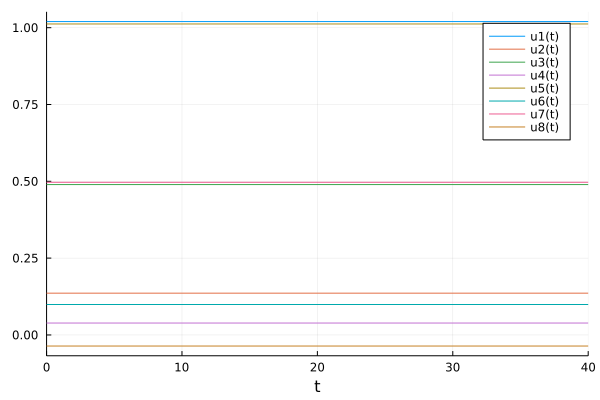

In [455]:
plot(results)

In [456]:
kp_vd = 0.59
ki_vd = 736.0
kp_id = 1.27
ki_id = 14.3

kp_vq = 0.59
ki_vq = 736.0
kp_iq = 1.27
ki_iq = 14.3

function inner_controls(vd_ref, vq_ref, vd, vq, id, iq, ϵd, γd, ϵq, γq)
    ω = 1.0
    # d-component controls
    dϵd = ki_vd * (vd_ref - vd) 
    id_ref = -ω*cf*vq + kp_vd * (v_d - vf_d) + ϵd
    
    dγd = ki_id * (id_ref - id)
    md = kp_id * (id_ref - if_d) + γd - ω*lf*iq
    
    # q-component controls
    dϵq = ki_vq * (vq_ref - vq)   
    iq_ref = ω*cf*vd + kp_vq * (v_q - vf_q) + ϵq   
    
    dγq = ki_iq * (iq_ref - iq)
    mq = kp_iq * (iq_ref - if_q) + γq + ω*lf*id
    
    return dϵd, dγd, dϵq, dγq, md, mq
end

inner_controls (generic function with 2 methods)

In [457]:
function simulate_all(dx, x, p, t)
    v = x[1]
    θ = x[2]
    if_d = x[3]
    if_q = x[4]
    vf_d = x[5]
    vf_q = x[6]
    it_d = x[7]
    it_q = x[8]
    ϵd = x[9]
    ϵq = x[10]
    γd = x[11]
    γq = x[12]
    v_d = v*cos(θ)
    v_q = v*sin(θ)
    ω = 1.0
    vinf_d = 1.0
    vinf_q = 0.0
    V_in = 1
    
    p, q = power_comp(v_d, v_q, if_d, if_q)
    
    #v_dvoc = norm(vf_d, vf_q)
    #θ_dvoc = atan(vf_q/vf_d)

    dv, dθ = dVOC(v, θ, it_d, it_q, κ, p, q)
    
    #v_d_ref = v_dvoc*cos(θ_dvoc)
    #v_q_ref = v_dvoc*sin(θ_dvoc)
    
    # added inner controls
    dϵd, dγd, dϵq, dγq, md, mq = inner_controls(v_d, v_q, vf_d, vf_q, if_d, if_q, ϵd, γd, ϵq, γq)
    
#     dif_d = ωᵦ/lf * (v_d - vf_d - rf*if_d + ω*lf*if_q)
#     dif_q = ωᵦ/lf * (v_q - vf_q - rf*if_q - ω*lf*if_d)
    
    # changed input
    dif_d = ωᵦ/lf * (md*V_in - vf_d - rf*if_d + ω*lf*if_q)
    dif_q = ωᵦ/lf * (mq*V_in - vf_q - rf*if_q - ω*lf*if_d)
    
    dvf_d = ωᵦ/cf * (if_d - it_d + ω*cf*vf_q)
    dvf_q = ωᵦ/cf * (if_q - it_q - ω*cf*vf_d)
    
    dit_d = ωᵦ/lf * (vf_d - vinf_d - rt*it_d + ω*lt*it_q)
    dit_q = ωᵦ/lf * (vf_q - vinf_q - rt*it_q - ω*lt*it_d)
   
    dx[1] = dv
    dx[2] = dθ
    dx[3] = dif_d
    dx[4] = dif_q
    dx[5] = dvf_d
    dx[6] = dvf_q
    dx[7] = dit_d
    dx[8] = dit_q    
    dx[9] = dϵd
    dx[10] = dγd
    dx[11] = dϵq
    dx[12] = dγq
    return
end

simulate_all (generic function with 1 method)

In [458]:
x0_guess_pf =  hcat(ress.zero, [0.01 0.01 0.01 0.01])

1×12 Matrix{Float64}:
 1.02  0.135978  0.48947  0.0386875  …  -0.0362162  0.01  0.01  0.01  0.01

In [459]:
res = nlsolve((dx, x) -> simulate_all(dx, x, p_ref, q_ref), x0_guess_pf)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.02 0.13597806904050008 0.48946981820043456 0.038687457049909835 1.012211190134107 0.0989969568918867 0.4967955930104342 -0.03621617102001409 0.01 0.01 0.01 0.01]
 * Zero: [1.0192249784644547 0.13341786222256838 0.668710796353075 0.05785376448661333 1.0101671580225853 0.13557975357140117 0.6787436981173587 -0.01689860520705797 0.6772575990504263 -0.04007287174286025 0.7845372481577911 0.11141210442024758]
 * Inf-norm of residuals: 0.000000
 * Iterations: 9
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 7
 * Jacobian Calls (df/dx): 6

In [462]:
x = res.zero
v = x[1]
θ = x[2]
if_d = x[3]
if_q = x[4]
vf_d = x[5]
vf_q = x[6]
it_d = x[7]
it_q = x[8]
ϵd = x[9]
ϵq = x[10]
γd = x[11]
γq = x[12]

0.11141210442024758

In [463]:
power_comp(v*cos(θ), v*sin(θ), if_d, if_q)

(0.6833534838232652, 0.03222167212773399)

In [238]:
using LinearAlgebra

In [239]:
norm([v_d, v_q])

1.02

In [240]:
v

1.019246520458609